In [14]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import joblib

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from src.Bayesian import *
from src.Bayesian.problems.config import config_fgt
from src.Bayesian.problems import *
from src.Bayesian.utils.optimizer import Optimizer
from src.Bayesian.utils.model_evaluation import ModelEval

In [21]:
# Example module config
module_config = {
    "perception": (BasePerception, {}),
    "memory": (BaseMemory, {
        "personal_memory_range": {
            "gamma": (0.05, 1.0),
            "w0": (0.075, 0.15)
        },
        "param_resolution": 20
    }),
    "cluster": (PartitionCluster, {
        "transition_spec": [("random_4", "top_posterior"),
                            ("opp_random_4", "random")]
    })
}
optimizer = Optimizer(module_config, n_jobs=10)

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

In [26]:
iSub = 1
results = optimizer.optimize_params_with_subs_parallel(
    config_fgt, [iSub], 16, 1, 3)

Processing tasks:   0%|                                                     | 0/400 [00:00<?, ?it/s]

Computing error for params: 100%|██████████| 3/3 [00:00<00:00, 3479.79it/s]


In [ ]:
# save results
result_path = Path(project_root) / 'results' / 'Model_results'
os.makedirs(result_path, exist_ok=True)

optimizer.save_results(results, 'M7_PMH_sub1', result_path)

In [32]:
from src.Bayesian.utils.stream import StreamList

def extract_top_trajectories(results, percentile=0.1):
    output = {}
    for iSub, info in results.items():
        if 'raw_step_results' not in info: continue
        path, n = info['raw_step_results']
        errors = info['sample_errors']
        top_k = max(1, int(n * percentile))
        top_idxs = np.argsort(errors)[:top_k]

        slist = StreamList(path, n)
        output[iSub] = [slist[int(i)] for i in top_idxs]
    return output


In [33]:
extract_top_trajectories(results, percentile=0.1)

{1: [[{'best_k': 11,
    'best_beta': 24.631930220115436,
    'best_params': {'k': 11,
     'beta': 24.631930220115436,
     'gamma': 0.95,
     'w0': 0.01},
    'best_log_likelihood': -1.3556865939467323e-05,
    'best_norm_posterior': 0.40001234620685044,
    'hypo_details': {1: {'beta_opt': 0.001,
      'll_max': -0.6931559330136011,
      'post_max': 0.2000071340178483,
      'is_best': False},
     11: {'beta_opt': 24.631930220115436,
      'll_max': -1.3556865939467323e-05,
      'post_max': 0.40001234620685044,
      'is_best': True},
     9: {'beta_opt': 30.0,
      'll_max': -9.312365439276392e-05,
      'post_max': 0.3999805197753013,
      'is_best': False}},
    'perception_stimuli': array([0.10236161, 0.52354972, 0.04092492, 0.64363796]),
    'best_step_amount': {'top_posterior': (0, []),
     'random': (4, [8, 0, 2, 1])}},
   {'best_k': 2,
    'best_beta': 30.0,
    'best_params': {'k': 2, 'beta': 30.0, 'gamma': 0.95, 'w0': 0.01},
    'best_log_likelihood': -0.00034285288

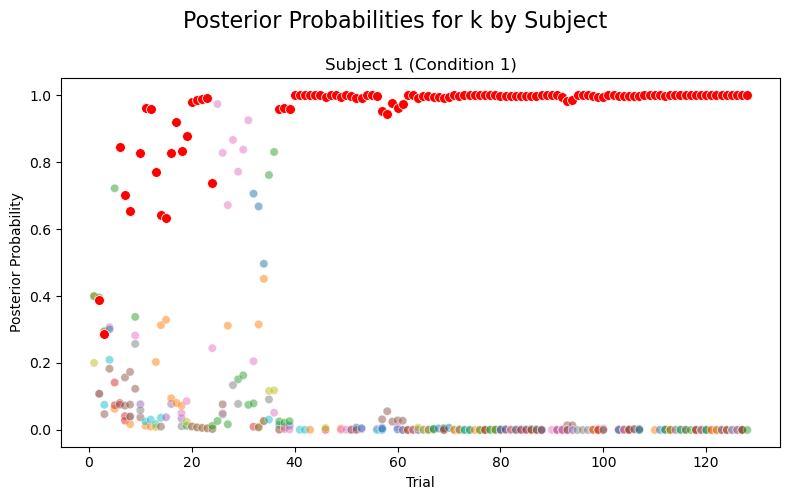

In [5]:
model_eval = ModelEval()
model_eval.plot_posterior_probabilities(results, [iSub])

In [6]:
optimizer.set_results(results)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt, [iSub])

Predicting tasks: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 1314.42it/s]

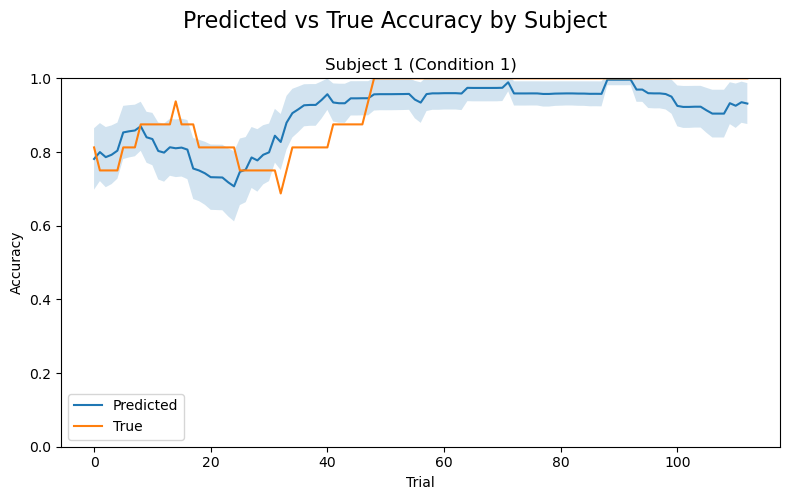

In [7]:
model_eval.plot_accuracy_comparison(prediction, [iSub])

In [8]:
from src.Bayesian.utils.oral_process import Oral_to_coordinate
oral_to_coordinate = Oral_to_coordinate()

learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')
oral_hypo_hits = oral_to_coordinate.get_oral_hypo_hits(learning_data)

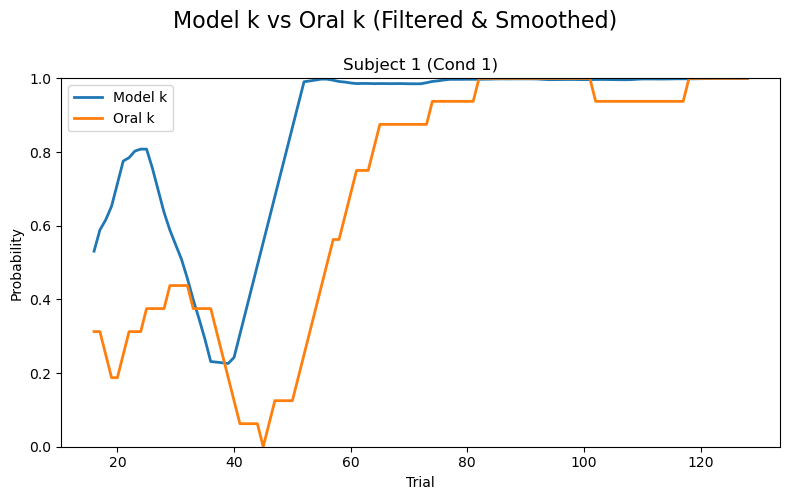

In [9]:
model_eval.plot_k_oral_comparison(results, oral_hypo_hits, [iSub])

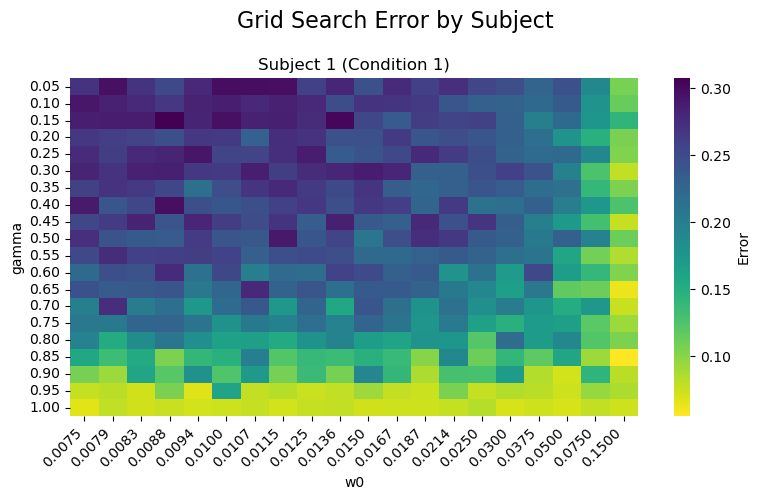

In [12]:
model_eval.plot_error_grids(results, fname=['gamma','w0'])

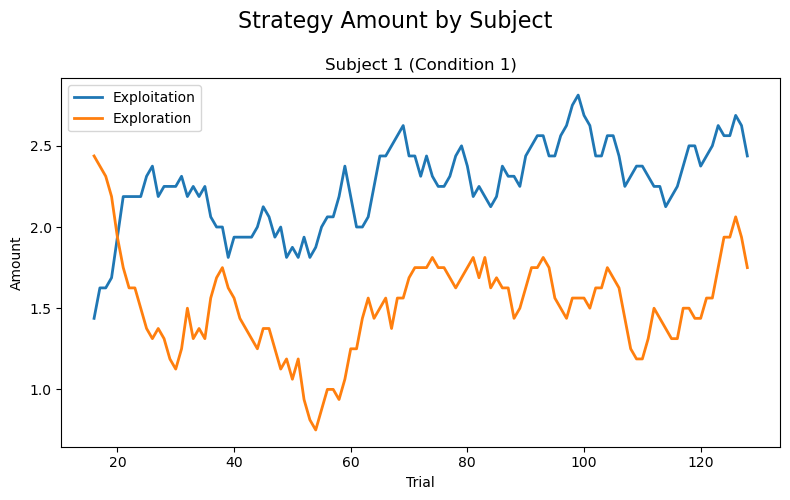

In [13]:
model_eval.plot_cluster_amount(results, 16, [iSub])